# 05 — Baseline Models

Evaluates two simple baselines on the validation folds:
1. **Majority Class**: always predict the most frequent class in the training set
2. **MACD Momentum Rule**: predict 1 (up) if MACD histogram > 0 (bullish crossover signal), else 0

In [1]:
import sys
import os
import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_FOLDER = "spy_run"
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

DATA_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "data_config.json"
MODEL_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "model_config.json"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / PROJECT_FOLDER
RESULTS_DIR = PROJECT_ROOT / "results" / PROJECT_FOLDER
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

from src.utils.config_loader import ConfigLoader
config = ConfigLoader(str(DATA_CONFIG), str(MODEL_CONFIG))
print(f"Project folder: {PROJECT_FOLDER}")

Project folder: spy_run


In [2]:
train_df = pd.read_parquet(PROCESSED_DIR / "train.parquet")
with open(PROCESSED_DIR / "val_folds.pkl", "rb") as f:
    val_folds = pickle.load(f)
with open(PROCESSED_DIR / "metadata.json") as f:
    metadata = json.load(f)

print(f"Train shape: {train_df.shape}")
print(f"Val folds: {len(val_folds)}")

Train shape: (4583, 14)
Val folds: 5


## Baseline 1: Majority Class

In [3]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

majority_class = int(train_df["target"].mode()[0])
print(f"Majority class: {majority_class} ({'Up' if majority_class == 1 else 'Down/Flat'})")

fold_results_majority = []
for i, (train_fold, val_fold) in enumerate(val_folds):
    y_true = val_fold["target"].values
    y_pred = np.full(len(y_true), majority_class)
    
    result = {
        "fold": i + 1,
        "n_val": len(y_true),
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_true, y_pred, zero_division=0), 4),
    }
    fold_results_majority.append(result)
    print(f"Fold {i+1}: accuracy={result['accuracy']:.4f}, f1={result['f1']:.4f}")

majority_df = pd.DataFrame(fold_results_majority)
print(f"\nAverage across folds:")
print(majority_df.drop(columns=["fold", "n_val"]).mean().round(4))

Majority class: 0 (Down/Flat)
Fold 1: accuracy=0.8060, f1=0.0000
Fold 2: accuracy=0.9069, f1=0.0000
Fold 3: accuracy=0.9096, f1=0.0000
Fold 4: accuracy=0.8414, f1=0.0000
Fold 5: accuracy=0.8296, f1=0.0000

Average across folds:
accuracy     0.8587
precision    0.0000
recall       0.0000
f1           0.0000
dtype: float64


In [4]:

# ── Majority Class Analysis ───────────────────────────────────────────────────
avg_maj = majority_df.drop(columns=["fold", "n_val"]).mean()

counts = train_df["target"].value_counts()
total  = len(train_df)
pct_0  = counts.get(0, 0) / total * 100
pct_1  = counts.get(1, 0) / total * 100

print("═" * 60)
print("MAJORITY CLASS BASELINE — ANALYSIS")
print("═" * 60)
print()
print(f"Class distribution in training set:")
print(f"  Class 0 (Down/Flat) : {counts.get(0,0):,}  ({pct_0:.1f}%)")
print(f"  Class 1 (Up ≥1%)    : {counts.get(1,0):,}  ({pct_1:.1f}%)")
print(f"  Imbalance ratio     : {pct_0/pct_1:.1f}:1")
print()
print(f"Performance (avg over {len(val_folds)} folds):")
print(f"  Accuracy  : {avg_maj['accuracy']:.4f}  ← inflated by class imbalance")
print(f"  Precision : {avg_maj['precision']:.4f}")
print(f"  Recall    : {avg_maj['recall']:.4f}  ← never detects an Up day")
print(f"  F1        : {avg_maj['f1']:.4f}  ← the floor to beat")
print()
print("Key takeaways:")
print(f"  • {pct_0:.0f}% of trading days have <1% return — simply predicting")
print(f"    'never buy' achieves {avg_maj['accuracy']*100:.1f}% accuracy.")
print(f"  • Accuracy is therefore a misleading metric for this problem.")
print(f"  • F1 = 0.000 is the absolute floor. Any ML model that learns")
print(f"    anything useful must achieve F1 > 0.")
print(f"  • The {pct_0/pct_1:.1f}:1 imbalance requires class_weight='balanced'")
print(f"    (LR/RF) and scale_pos_weight={pct_0/pct_1:.2f} (XGBoost).")

# Fold-to-fold accuracy variation reveals class composition shifts over time
acc_std = majority_df["accuracy"].std()
print()
print(f"  • Fold accuracy std = {acc_std:.4f} — class ratio shifts across time periods")
print(f"    (Fold 2/3 accuracy ~{majority_df['accuracy'].max():.2f} vs Fold 1 ~{majority_df['accuracy'].min():.2f})")
print(f"    indicating some periods have fewer Up days than others.")


════════════════════════════════════════════════════════════
MAJORITY CLASS BASELINE — ANALYSIS
════════════════════════════════════════════════════════════

Class distribution in training set:
  Class 0 (Down/Flat) : 3,939  (85.9%)
  Class 1 (Up ≥1%)    : 644  (14.1%)
  Imbalance ratio     : 6.1:1

Performance (avg over 5 folds):
  Accuracy  : 0.8587  ← inflated by class imbalance
  Precision : 0.0000
  Recall    : 0.0000  ← never detects an Up day
  F1        : 0.0000  ← the floor to beat

Key takeaways:
  • 86% of trading days have <1% return — simply predicting
    'never buy' achieves 85.9% accuracy.
  • Accuracy is therefore a misleading metric for this problem.
  • F1 = 0.000 is the absolute floor. Any ML model that learns
    anything useful must achieve F1 > 0.
  • The 6.1:1 imbalance requires class_weight='balanced'
    (LR/RF) and scale_pos_weight=6.12 (XGBoost).

  • Fold accuracy std = 0.0470 — class ratio shifts across time periods
    (Fold 2/3 accuracy ~0.91 vs Fold 1 ~

## Baseline 2: MACD Momentum Rule (MACD_hist > 0)

In [5]:
fold_results_momentum = []
for i, (train_fold, val_fold) in enumerate(val_folds):
    y_true = val_fold["target"].values

    if "MACD_hist" in val_fold.columns:
        # MACD_hist > 0: bullish crossover (MACD line crossed above signal line)
        # Works on normalized data — sign is preserved after Z-scoring
        y_pred = (val_fold["MACD_hist"] > 0).astype(int).values
    else:
        print(f"Fold {i+1}: MACD_hist not found, falling back to majority class")
        y_pred = np.full(len(y_true), majority_class)

    result = {
        "fold": i + 1,
        "n_val": len(y_true),
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_true, y_pred, zero_division=0), 4),
    }
    fold_results_momentum.append(result)
    print(f"Fold {i+1}: accuracy={result['accuracy']:.4f}, f1={result['f1']:.4f}")

momentum_df = pd.DataFrame(fold_results_momentum)
print(f"\nAverage across folds:")
print(momentum_df.drop(columns=["fold", "n_val"]).mean().round(4))

Fold 1: accuracy=0.4967, f1=0.2441
Fold 2: accuracy=0.5007, f1=0.1077
Fold 3: accuracy=0.4902, f1=0.1098
Fold 4: accuracy=0.4836, f1=0.1992
Fold 5: accuracy=0.4666, f1=0.2218

Average across folds:
accuracy     0.4876
precision    0.1163
recall       0.3884
f1           0.1765
dtype: float64


In [6]:

# ── MACD Momentum Baseline Analysis ──────────────────────────────────────────
avg_mom = momentum_df.drop(columns=["fold", "n_val"]).mean()
f1_std  = momentum_df["f1"].std()

print("═" * 60)
print("MACD MOMENTUM BASELINE — ANALYSIS")
print("═" * 60)
print()
print(f"Performance (avg over {len(val_folds)} folds):")
print(f"  Accuracy  : {avg_mom['accuracy']:.4f}  ← worse than majority class")
print(f"  Precision : {avg_mom['precision']:.4f}  ← only 1 in {1/avg_mom['precision']:.0f} buy signals correct")
print(f"  Recall    : {avg_mom['recall']:.4f}  ← catches ~{avg_mom['recall']*100:.0f}% of actual Up days")
print(f"  F1        : {avg_mom['f1']:.4f}  (std={f1_std:.4f} across folds)")
print()
print("Per-fold F1 breakdown:")
for _, row in momentum_df.iterrows():
    bar = "█" * int(row["f1"] * 40)
    print(f"  Fold {int(row['fold'])}: {row['f1']:.4f}  {bar}")
print()
print("Key takeaways:")
print(f"  • MACD_hist > 0 fires on ~50% of days (crosses zero frequently),")
print(f"    but only ~{pct_1:.0f}% of days actually have ≥1% returns.")
print(f"    Result: high recall ({avg_mom['recall']:.2f}) but very low precision ({avg_mom['precision']:.2f}).")
print(f"  • Accuracy ({avg_mom['accuracy']:.2f}) drops below chance — the rule generates")
print(f"    too many false buy signals, hurting overall correctness.")
print(f"  • F1 std = {f1_std:.4f} across folds — significant variance suggests")
print(f"    MACD momentum is regime-dependent (works in some periods, not others).")
print(f"  • Fold 2 F1={momentum_df.iloc[1]['f1']:.4f} is the weakest, suggesting the MACD")
print(f"    signal breaks down during specific market conditions.")
print()
print("Precision-Recall trade-off insight:")
print(f"  The MACD rule is a high-recall, low-precision strategy. For a")
print(f"  profitable trading signal, we need much higher precision — the")
print(f"  cost of a false buy (entering a losing trade) outweighs the")
print(f"  cost of a missed opportunity. ML models should improve precision")
print(f"  by conditioning on multiple features simultaneously.")


════════════════════════════════════════════════════════════
MACD MOMENTUM BASELINE — ANALYSIS
════════════════════════════════════════════════════════════

Performance (avg over 5 folds):
  Accuracy  : 0.4876  ← worse than majority class
  Precision : 0.1163  ← only 1 in 9 buy signals correct
  Recall    : 0.3884  ← catches ~39% of actual Up days
  F1        : 0.1765  (std=0.0639 across folds)

Per-fold F1 breakdown:
  Fold 1: 0.2441  █████████
  Fold 2: 0.1077  ████
  Fold 3: 0.1098  ████
  Fold 4: 0.1992  ███████
  Fold 5: 0.2218  ████████

Key takeaways:
  • MACD_hist > 0 fires on ~50% of days (crosses zero frequently),
    but only ~14% of days actually have ≥1% returns.
    Result: high recall (0.39) but very low precision (0.12).
  • Accuracy (0.49) drops below chance — the rule generates
    too many false buy signals, hurting overall correctness.
  • F1 std = 0.0639 across folds — significant variance suggests
    MACD momentum is regime-dependent (works in some periods, not o

## Baseline Comparison

Baseline Comparison (averaged across validation folds):
                accuracy  precision  recall      f1
Majority Class    0.8587     0.0000  0.0000  0.0000
MACD Momentum     0.4876     0.1163  0.3884  0.1765


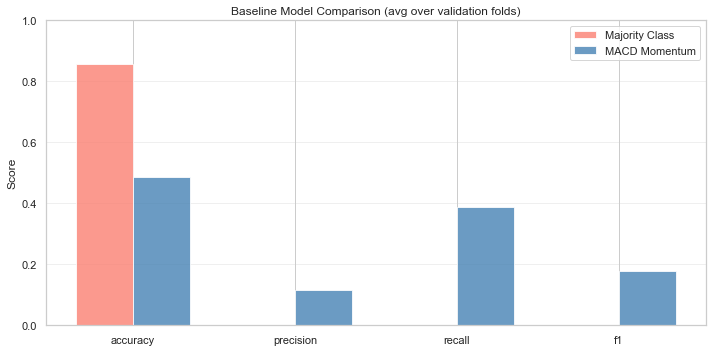


Baseline results saved.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

avg_majority = majority_df.drop(columns=["fold", "n_val"]).mean()
avg_momentum = momentum_df.drop(columns=["fold", "n_val"]).mean()

comparison = pd.DataFrame({
    "Majority Class": avg_majority,
    "MACD Momentum": avg_momentum,
}).T

print("Baseline Comparison (averaged across validation folds):")
print(comparison.round(4))

fig, ax = plt.subplots(figsize=(10, 5))
metrics = ["accuracy", "precision", "recall", "f1"]
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, [avg_majority[m] for m in metrics], width, label="Majority Class", color="salmon", alpha=0.8)
ax.bar(x + width/2, [avg_momentum[m] for m in metrics], width, label="MACD Momentum", color="steelblue", alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_title("Baseline Model Comparison (avg over validation folds)")
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "baseline_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

baseline_results = {
    "majority_class": avg_majority.to_dict(),
    "macd_momentum": avg_momentum.to_dict(),
}
with open(RESULTS_DIR / "baseline_results.json", "w") as f:
    json.dump(baseline_results, f, indent=2)
print("\nBaseline results saved.")

In [8]:

# ── Overall Summary & ML Targets ──────────────────────────────────────────────
avg_maj = majority_df.drop(columns=["fold", "n_val"]).mean()
avg_mom = momentum_df.drop(columns=["fold", "n_val"]).mean()
f1_std  = momentum_df["f1"].std()

print("═" * 62)
print("BASELINE SUMMARY — TARGETS FOR ML MODELS")
print("═" * 62)
print()
print(f"{'Baseline':<22} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>8}")
print("-" * 62)
print(f"{'Majority Class':<22} {avg_maj['accuracy']:>10.4f} {avg_maj['precision']:>10.4f} {avg_maj['recall']:>10.4f} {avg_maj['f1']:>8.4f}")
print(f"{'MACD Momentum':<22} {avg_mom['accuracy']:>10.4f} {avg_mom['precision']:>10.4f} {avg_mom['recall']:>10.4f} {avg_mom['f1']:>8.4f}")
print()
print("What ML models must achieve to be useful:")
print(f"  ✓ F1 > {avg_mom['f1']:.4f}  (beat MACD momentum baseline)")
print(f"  ✓ Precision > {avg_mom['precision']:.4f}  (better buy signal quality)")
print(f"  ✓ Consistent F1 across folds (std < {f1_std:.4f} of MACD baseline)")
print()
print("Primary evaluation metric: F1")
print("  F1 balances precision and recall. For a trading signal,")
print("  precision matters most (fewer false buys = fewer losing trades),")
print("  but recall must stay reasonable (can't miss all Up days).")
print()

counts = train_df["target"].value_counts()
pct_class1 = counts.get(1, 0) / len(train_df) * 100
print("Why accuracy is not the primary metric:")
print(f"  A model that always says 'don't buy' scores {avg_maj['accuracy']*100:.1f}% accuracy")
print(f"  yet has zero utility. F1 correctly penalises this behaviour.")
print()
print("Next step → Notebook 06: Train LR, Random Forest, XGBoost with HPT.")
print(f"Target: F1 > {avg_mom['f1']:.2f}, Precision > {avg_mom['precision']:.2f}, stable across all 5 folds.")


══════════════════════════════════════════════════════════════
BASELINE SUMMARY — TARGETS FOR ML MODELS
══════════════════════════════════════════════════════════════

Baseline                 Accuracy  Precision     Recall       F1
--------------------------------------------------------------
Majority Class             0.8587     0.0000     0.0000   0.0000
MACD Momentum              0.4876     0.1163     0.3884   0.1765

What ML models must achieve to be useful:
  ✓ F1 > 0.1765  (beat MACD momentum baseline)
  ✓ Precision > 0.1163  (better buy signal quality)
  ✓ Consistent F1 across folds (std < 0.0639 of MACD baseline)

Primary evaluation metric: F1
  F1 balances precision and recall. For a trading signal,
  precision matters most (fewer false buys = fewer losing trades),
  but recall must stay reasonable (can't miss all Up days).

Why accuracy is not the primary metric:
  A model that always says 'don't buy' scores 85.9% accuracy
  yet has zero utility. F1 correctly penalises this